# Titanic Visualization Exercise
Your goal in this exercise is to communicate and present findings in a visual and comprehensible way. \
The data you will work on is the titanic passengers data, you can find it titanic.xls file.

**The table columns are as follows:**
- passengerID
- Survived - did the passenger survived
- Pclass - passenger class
- Name
- Sex
- Age
- Sibsp - number of siblings and/or spouse on board
- Parch - number of parents/children on board
- Fare - ticket fare
- Cabin - room number
- Embarked - the port the passenger embarked from

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
# sns.set_theme()
# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
def plot_wrapper(g, xlim=None, context='talk', size=(8,6), suptitle=None):
    sns.set(rc={'figure.facecolor':'white'})
    sns.set_context(context)
    g.fig.set_size_inches(size[0], size[1])
    if suptitle is not None:
        g.fig.suptitle(suptitle, fontsize=32, y=1.05)
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    plt.show()

## Loading and preprocessing

Before asking major questions, let's see what kind of data we are dealing with.

In [2]:
df = pd.read_excel('titanic.xls')

In [3]:
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [4]:
nan_summary = df.isna().sum()
nan_summary = nan_summary[nan_summary > 0].sort_values(ascending=False)
nan_summary = nan_summary.reset_index()
nan_summary.columns = ['Column', 'NaN Count']
nan_summary['NaN Ratio'] = np.round(nan_summary['NaN Count'] / df.shape[0],2)
nan_summary

,Column,NaN Count,NaN Ratio
0,body,1188,0.91
1,cabin,1014,0.77
2,boat,823,0.63
3,home.dest,564,0.43
4,age,263,0.20
5,embarked,2,0.00
6,fare,1,0.00


In [5]:
df[df['pclass']==1]['cabin'].isna().sum() / (df['pclass'] == 1).sum()

0.20743034055727555

We will also be interested in the last names and the titles (such as Mr., Miss., etc.).
The average age per title could aid us in amputating the missing ages.

In [6]:
df['surname'] = df['name'].apply(lambda x: x.split(',')[0])
df['titlename'] = df['name'].apply(lambda x: x.split(',')[1].split(' ')[1])
df['country.dest'] = df['home.dest'].apply(lambda x: x.split(' ')[-1] if isinstance(x, str) else '?')
df['died'] = df['survived'].apply(lambda x: 0 if x == 1 else 1)
# df['survived'] = df['survived'].map({0: 'dead', 1: 'alive'}).astype('category')
df['deck'] = df['cabin'].apply(lambda x: x[0] if isinstance(x, str) else '?')
df['family_id'] = df['surname'].astype(str) + '-' + df['ticket'].astype(str)
df['family_size'] = df['sibsp'] + df['parch'] + 1
df.drop(['body', 'home.dest', 'boat'], inplace=True, axis=1)

While amputating per class, by substituting the mean age in that class, perhaps a more exact amputation will also rely on the title we extracted from the full name. 

## Questions

- How is age distributed in every pclass? in each sex? in each title?
- Which family had lost the most members? Can we ensure that no two families share the same name?
- Is there a connection between the age of a passenger and it's chance of survival? What about his pclass? What other features aid in predicting survivability?
- What is the relation between survivors to deceased in every pclass?
- How fares distribute in different classes? Are they uniform within each class?

## Age distribution

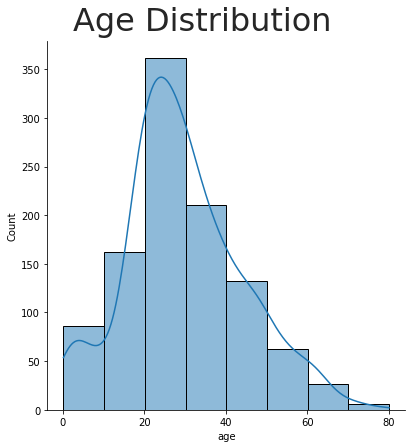

In [7]:
plot_wrapper(sns.displot(data=df, x='age', bins=8, kde=True, stat='count'), size=(6,6), suptitle='Age Distribution')

Mostly young people. Let's now see how age distributes per passenger class.

While the above plot depicts the count for each passenger class, let us normalize each class and overlay the KDE approximations to get another angle.

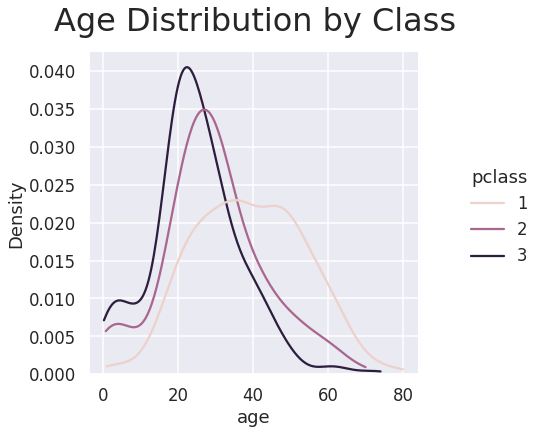

In [8]:
plot_wrapper(sns.displot(data=df, x='age', hue='pclass', common_norm=False, kind='kde', cut=0),
             suptitle='Age Distribution by Class', size=(8,6))

Interesting. We can see that as we go down the classes, the age distribution becomes more left skewed, including more younger people and children. 

Let's try to use the titles we extracted to look into a finer level of granularity.

In [9]:
groupby_title_class = df.groupby(['titlename', 'pclass'])
count_index = df.groupby(['titlename'])['age'].count().sort_values(ascending=False).drop('the')

fig = px.imshow(groupby_title_class['age'].mean().round(1).unstack().loc[count_index.index],
                text_auto=True, color_continuous_scale="Viridis", 
                labels=dict(x="Pclass", y="Title Name", color="Age"), 
                title="Average Age by Title Name and Passenger Class (count in brackets)")
fig.update_xaxes(tickvals=[1, 2, 3], ticktext=[1, 2, 3])
fig.update_layout(width=800, height=600)

# Add counts as shifted annotations
age_mean = groupby_title_class['age'].mean().unstack().loc[count_index.index]
age_counts = groupby_title_class['age'].count().unstack().loc[count_index.index]

for i, title in enumerate(age_mean.index):
    for j, pclass in enumerate(age_mean.columns):
        count = age_counts.loc[title, pclass]
        if pd.notna(count):  # Only add if the count is not NaN
            fig.add_annotation(
                x=j + 1.2, y=i - 0.25,  # Shift up slightly
                text=f"({int(count)})",  # Format the count as an integer
                showarrow=False,
                font=dict(color="white", size=10),
                xref="x", yref="y"
            )

fig.show()

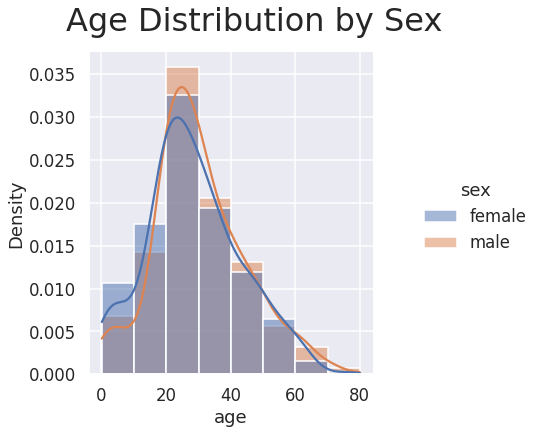

In [10]:
plot_wrapper(sns.displot(data=df, x='age', hue='sex', common_norm=False, kind='hist', kde=True, bins=8, stat='density'),
             suptitle='Age Distribution by Sex', size=(8,6))

It seems that the male distribution is shifted a bit to the right compared to the female distribution. The empirical cumulative distribution function will aid us in seeing this. 

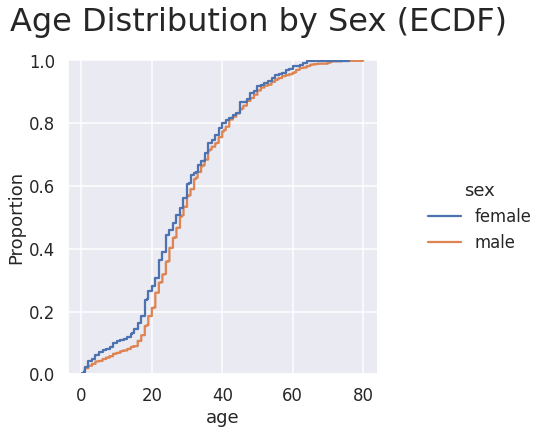

In [11]:
plot_wrapper(sns.displot(data=df, x='age', hue='sex', kind='ecdf'),
             suptitle='Age Distribution by Sex (ECDF)', size=(8,6))

Indeed, females are slightly younger, but otherwise the distributions are rather similar.

## What predicts survivability?

We are (mainly) interested in seeing how various features relate to the survivability of the passengers. Let's start considering it.

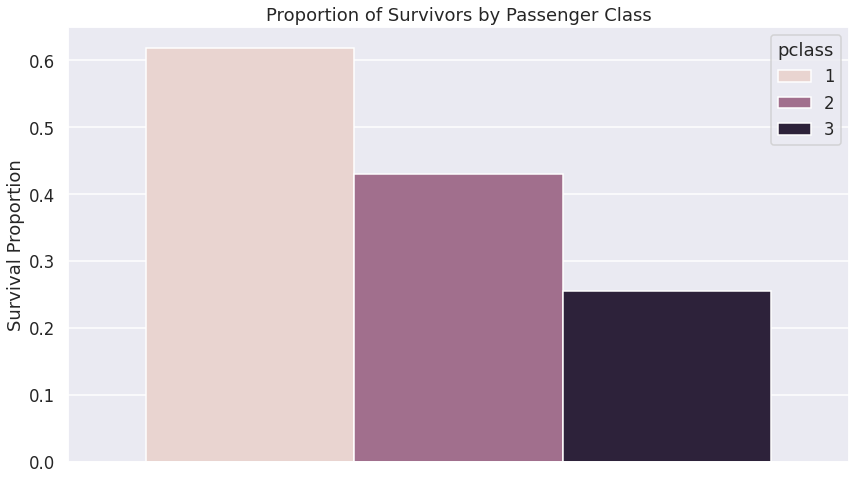

In [12]:
plt.figure(figsize=(14, 8))
sns.barplot(data=df, y='survived', hue='pclass',errorbar=None)
plt.xticks(rotation=45)
plt.title("Proportion of Survivors by Passenger Class")
plt.ylabel("Survival Proportion")
plt.show()

As expected. Let's incorporate age as well.

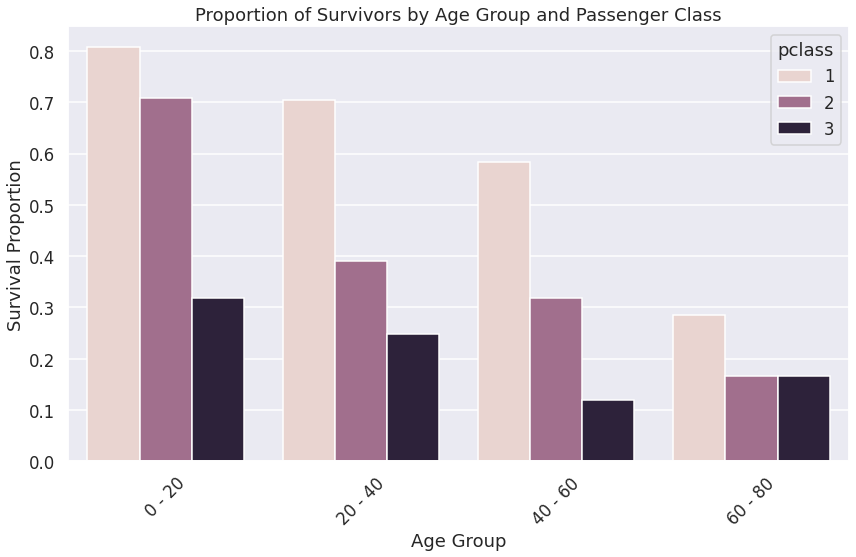

In [13]:
n_bins = 4
bins = np.linspace(df['age'].min(), df['age'].max(), n_bins + 1)

df['age_bin'] = pd.cut(df['age'], bins=bins)

survival_rate = df.groupby(['age_bin', 'pclass'])['survived'].mean().reset_index()
# survival_rate['survived'] *= 100  # Convert to percentage
survival_rate['age_bin'] = survival_rate['age_bin'].apply(lambda x: f"{x.left:.0f} - {x.right:.0f}")

plt.figure(figsize=(14, 8))
sns.barplot(data=survival_rate, x='age_bin', y='survived', hue='pclass')
plt.xticks(rotation=45)
plt.title("Proportion of Survivors by Age Group and Passenger Class")
plt.ylabel("Survival Proportion")
plt.xlabel("Age Group")
plt.show()

## Families

We were interested in which family suffered the most casualties.

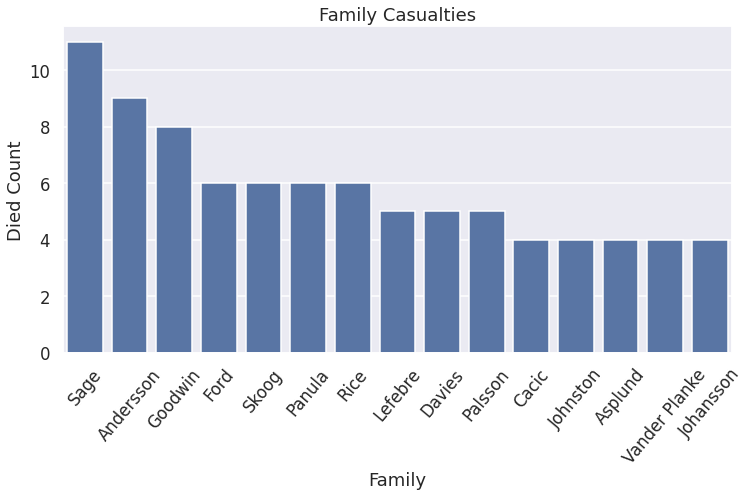

In [14]:
plt.figure(figsize=(12, 6))

sns.barplot(data=df.groupby('surname')['died'].sum().sort_values(ascending=False).reset_index().head(15),
            y="died", x="surname")

plt.title("Family Casualties")
plt.xticks(rotation=50)
plt.ylabel("Died Count")
plt.xlabel("Family")
plt.show()

**But this might be misleading!** What if there are several families abroad with the same surname? "Andersson" is quite ubiquitous.

In [15]:
df[df['surname'] == 'Andersson'][['name', 'age', 'ticket', 'sibsp', 'parch', 'country.dest', 'fare']].sort_values('ticket')

,name,age,ticket,sibsp,parch,country.dest,fare
625,"Andersson, Miss. Erna Alexandra",17.0,3101281,4,2,NY,7.9250
631,"Andersson, Mr. Johan Samuel",26.0,347075,0,0,CT,7.7750
622,"Andersson, Master. Sigvard Harald Elias",4.0,347082,4,2,MN,31.2750
623,"Andersson, Miss. Ebba Iris Alfrida",6.0,347082,4,2,MN,31.2750
624,"Andersson, Miss. Ellis Anna Maria",2.0,347082,4,2,MN,31.2750
627,"Andersson, Miss. Ingeborg Constanzia",9.0,347082,4,2,MN,31.2750
628,"Andersson, Miss. Sigrid Elisabeth",11.0,347082,4,2,MN,31.2750
629,"Andersson, Mr. Anders Johan",39.0,347082,1,5,MN,31.2750
632,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",39.0,347082,1,5,MN,31.2750
626,"Andersson, Miss. Ida Augusta Margareta",38.0,347091,4,2,MI,7.7750


Indeed, as we suspected, not every Andersson belongs to the same family! Firstly, two of them have no relatives abroad! However, it seems that, at least for this surname, the same ticket '347082' indicates the Andersson family of 4 siblings/spouses.

Simply appending the ticket name to the surname should provide a better family identifier.

In [16]:
inconsistent_groups_before = df.groupby('surname')['family_size'].nunique().ne(1)
inconsistent_groups_after = df.groupby('family_id')['family_size'].nunique().ne(1)
before = inconsistent_groups_before.sum() / df.groupby('surname').ngroups 
after = inconsistent_groups_after.sum() / df.groupby('family_id').ngroups
print(before, after)

0.056 0.015625


It doesn't solve all inconsistencies, let's see an example.

In [17]:
df[df['family_id']==inconsistent_groups_after[inconsistent_groups_after].index[0]]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,surname,titlename,country.dest,died,deck,family_id,family_size,age_bin
655,3,0,"Backstrom, Mr. Karl Alfred",male,32.0,1,0,3101278,15.85,NaN,S,Backstrom,Mr.,NY,1,?,Backstrom-3101278,2,"(20.125, 40.083]"
656,3,1,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",female,33.0,3,0,3101278,15.85,NaN,S,Backstrom,Mrs.,NY,0,?,Backstrom-3101278,4,"(20.125, 40.083]"


It appears the married couple has a shared ticket, though the woman (who has her husband's surname) has two more siblings abroad. We will stop here :)

In [18]:
df1 = df[['titlename', 'family_id', 'age', 'sex','survived']]
families_index = df.groupby('family_id').size().sort_values(ascending=False).index
df1 = df1.set_index('family_id').loc[families_index].reset_index()
family_casualties = pd.DataFrame(df.groupby('family_id')['died'].sum().sort_values(ascending=False)).reset_index()
family_casualties['family_id'] = family_casualties['family_id'].apply(lambda x: x.split('-')[0])

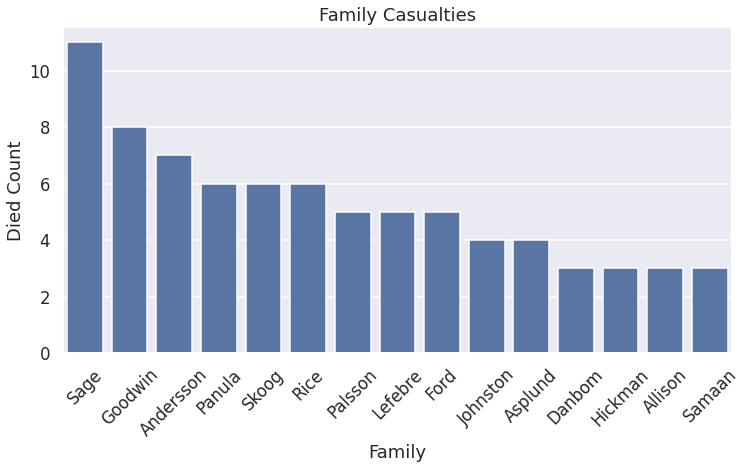

In [19]:
plt.figure(figsize=(12, 6))

sns.barplot(data=family_casualties.head(15),
            y="died", x="family_id")

plt.title("Family Casualties")
plt.xticks(rotation=45)
plt.ylabel("Died Count")
plt.xlabel("Family")
plt.show()

While the top result still holds true, note the correction in the Andersson case we witnessed above.

## Fares

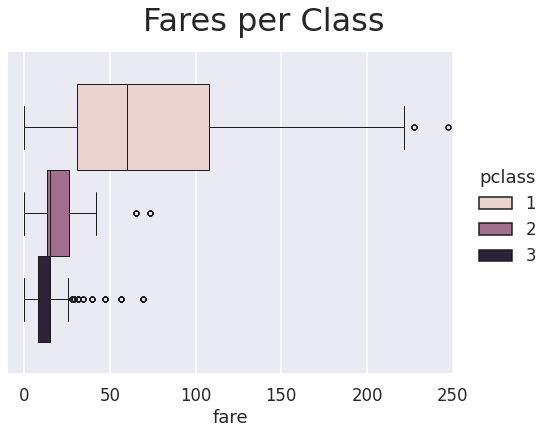

In [20]:
plot_wrapper(sns.catplot(data=df, x='fare', hue='pclass', kind='box'), xlim=(-10,250), suptitle='Fares per Class')

What causes variance in fare? We previously saw that families share the same ticket, so perhaps the fare relates to the total price.

In [21]:
df.groupby('family_id')['fare'].nunique().ne(1).sum()

1

Thus we can normalize by family size to get individual fare.

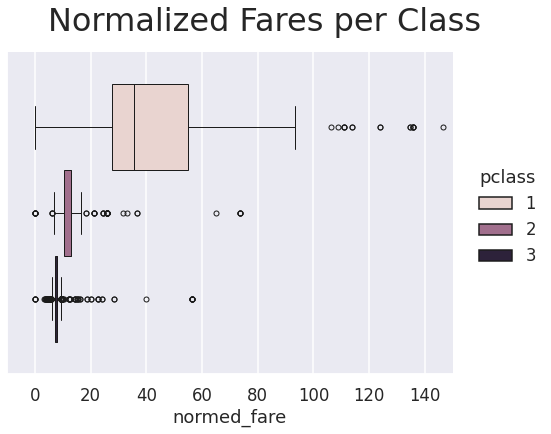

In [22]:
# Calculate the normalized fare per family
df['normed_fare'] = df.groupby('family_id')['fare'].transform(lambda x: x.mean() / len(x))
plot_wrapper(sns.catplot(data=df, x='normed_fare', hue='pclass', kind='box'), xlim=(-10,150), suptitle='Normalized Fares per Class')

Now prices are more uniform (yet outliers in each class). Still first class has some variance, perhaps they had many types of suites to choose from. Another source of variance may be where they embarked from, and where they were headed towards.

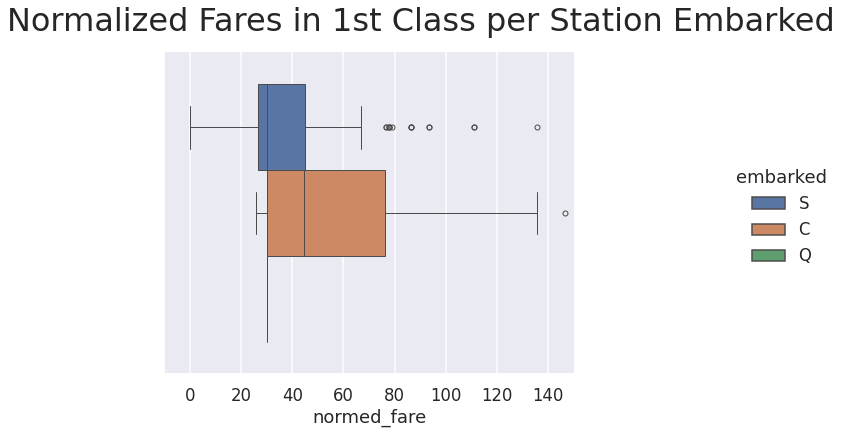

In [23]:
plot_wrapper(sns.catplot(data=df[df['pclass']==1], x='normed_fare', hue='embarked', kind='box'), xlim=(-10,150), suptitle='Normalized Fares in 1st Class per Station Embarked')

A later plot explain the anomaly in Q box - only 3 1st class passengers boarded from Q (Minhan family, see below).

In [24]:
df.groupby('family_id')['deck'].nunique().ne(1).sum()

2

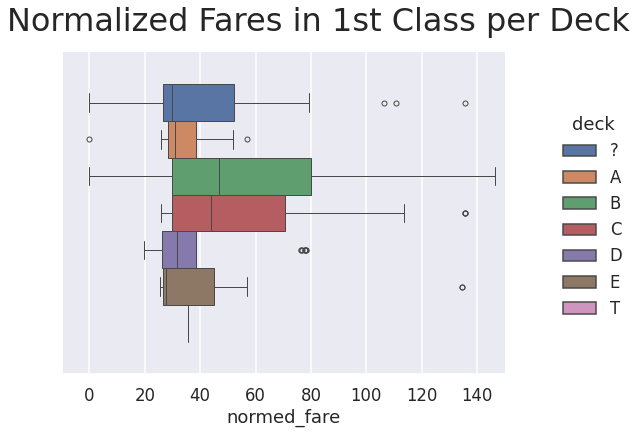

In [25]:
plot_wrapper(sns.catplot(data=df[df['pclass']==1].sort_values('deck'), x='normed_fare', hue='deck', kind='box'), xlim=(-10,150), suptitle='Normalized Fares in 1st Class per Deck')

Perhaps not enough info to explain this nonuniformity...

## Embarked

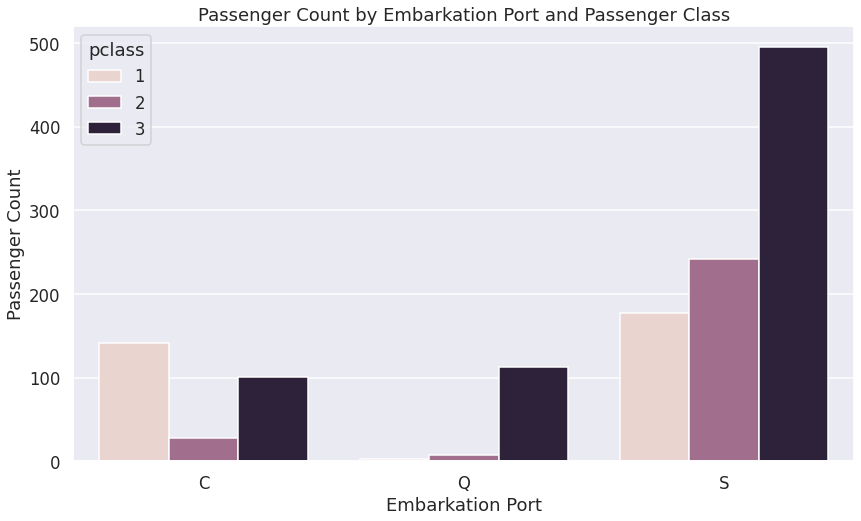

In [26]:
# Count the number of passengers per 'embarked' and 'pclass' group
count_data = df.groupby(['embarked', 'pclass']).size().reset_index(name='count')

# Plot the barplot
plt.figure(figsize=(14, 8))
sns.barplot(data=count_data, x='embarked', y='count', hue='pclass')
plt.title("Passenger Count by Embarkation Port and Passenger Class")
plt.ylabel("Passenger Count")
plt.xlabel("Embarkation Port")
plt.show()

The majority of first-class passengers had already embarked at Southampton and Cherbourg. Queenstown was not a major hub for affluent travelers, and its infrastructure was geared more toward accommodating emigrants than wealthy individuals. Additionally, the first-class passengers who did board at Queenstown, such as the Minahan family, had purchased their tickets in London and had initially planned to embark at Southampton.

https://chatgpt.com/share/6820b4c4-f9f0-800e-8b67-fda3b7e39ed6

## Logisitic regression coefficient hypothesis testing

Perhaps we can make our prior musings a bit more rigorous, via fitting a logistic regression model and examining the statistical significance of each coefficient corresponding to a feature.

In [27]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def classify_age_group(age):
    if age>=0 and age<20:
        return '0-20'
    elif age>=20 and age<40:
        return '20-40'
    elif age>=40 and age<60:
        return '40-60'
    else:
        return '60-80'
        
df['age_group'] = df['age'].apply(classify_age_group)
df['normed_age'] = df['age'] / df['age'].max()
df['normed_family_size'] = df['family_size'] / df['family_size'].max()
model = smf.logit('survived ~ normed_age + C(sex) + C(pclass)', data=df).fit()

# Print the model summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.469624
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                 1046
Model:                          Logit   Df Residuals:                     1041
Method:                           MLE   Df Model:                            4
Date:                Mon, 12 May 2025   Pseudo R-squ.:                  0.3055
Time:                        11:11:21   Log-Likelihood:                -491.23
converged:                       True   LL-Null:                       -707.31
Covariance Type:            nonrobust   LLR p-value:                 3.109e-92
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.5221      0.327     10.780      0.000       2.882       4.162
C(sex)[T.male]   

The coefficients make sense, in light of the above plots.